# Notebook to run Annotation Wild type mouse Heart to other genotypes - Lymphoid

**Created by** : Srivalli Kolla

**Created on** : 4 October, 2024

**Modified on** : 6 October, 2024

**Institute of Systems Immunology, University of Würzburg**

Env : scvi-env

# Import Packages

In [336]:
import scvi
import torch
import anndata
import warnings
import time
import datetime
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
import scib_metrics
import scib
import faiss
import matplotlib.pyplot as plt

from scib_metrics.nearest_neighbors import NeighborsResults
from pywaffle import Waffle
from scib_metrics.benchmark import Benchmarker, BioConservation

In [337]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

timestamp = datetime.datetime.now().strftime("%d_%m_%y")

-----
anndata     0.10.8
scanpy      1.10.2
-----
Cython              3.0.11
PIL                 10.3.0
absl                NA
array_api_compat    1.7.1
asttokens           NA
attr                23.2.0
chex                0.1.86
colorama            0.4.6
comm                0.2.2
contextlib2         NA
cycler              0.12.1
cython              3.0.11
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.8.2
decorator           5.1.1
deprecated          1.2.14
django              5.0.6
docrep              0.3.2
etils               1.9.2
executing           2.0.1
faiss               1.8.0
filelock            3.15.4
flax                0.8.5
fsspec              2024.6.1
h5py                3.11.0
igraph              0.11.6
importlib_resources NA
ipykernel           6.29.5
ipywidgets          8.1.5
jax                 0.4.30
jaxlib              0.4.30
jedi                0.19.1
joblib              1.4.2
kiwisolver          1.4.5
legacy_api_wrap     NA
leidenalg

In [338]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

Seed set to 1712


In [339]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 2,
)


# Import Data

## Reference

In [340]:
ref = sc.read_h5ad('../../data/dmd_annotated_lymphoid_wt_06_10_24.h5ad')
ref

AnnData object with n_obs × n_vars = 189 × 32285
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt', 'ribo', 'n_cells_by_counts'

In [341]:
ref.obs['genotype'].value_counts()

genotype
WT    189
Name: count, dtype: int64

In [342]:
ref.obs['cell_type'].value_counts()

cell_type
Lymphoid    189
Name: count, dtype: int64

In [343]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

In [344]:
print(X_is_raw(ref))

False


In [345]:
ref.X = ref.layers['raw_counts']
ref

AnnData object with n_obs × n_vars = 189 × 32285
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt', 'ribo', 'n_cells_by_counts'

In [346]:
print(X_is_raw(ref))

True


In [347]:
sc.pp.filter_cells(ref, min_genes = 200)
sc.pp.filter_cells(ref, min_counts = 100)
ref

AnnData object with n_obs × n_vars = 189 × 32285
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt', 'ribo', 'n_cells_by_counts'

In [348]:
ref.obs['cell_type'].value_counts()

cell_type
Lymphoid    189
Name: count, dtype: int64

In [349]:
sc.pp.highly_variable_genes(ref,    flavor = "seurat_v3",
    n_top_genes = 8000,
    layer = "raw_counts",
    batch_key = "sample", subset= True, span = 1 )

ref

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 189 × 8000
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt', 'ribo', 'n_cells_by_counts',

## Query

In [350]:
query_all = sc.read_h5ad('../../data/dmd_annotated_mdx,mdxscid_all_celltypes_06_10_24.h5ad')
query_all

AnnData object with n_obs × n_vars = 63315 × 32285
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt', 'ribo', 'n_cells_by_count

In [351]:
query_all.obs['cell_type'].value_counts()

cell_type
Ventricular Cardiomyocyte     27641
Endothelial cell              15626
Fibroblast                     9143
Myeloid                        6669
Mural cell                     3427
Lymphoid                        781
Neural cell                      21
Lymphatic Endothelial cell        3
Adipocyte                         2
Mesothelial cell                  1
Mast cell                         1
Name: count, dtype: int64

### Subsetting data

In [352]:
query = query_all[query_all.obs['cell_type'] == 'Lymphoid']
query

View of AnnData object with n_obs × n_vars = 781 × 32285
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt', 'ribo', 'n_cells_by

In [353]:
query.obs['cell_state'] = 'Unknown'

In [354]:
print (X_is_raw(query))

False


In [355]:
query.X = query.layers['raw_counts']

In [356]:
print (X_is_raw(query))

True


In [357]:
sc.pp.filter_cells(query, min_genes = 200)
sc.pp.filter_cells(query, min_counts = 100)
query

AnnData object with n_obs × n_vars = 781 × 32285
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt', 'ribo', 'n_cells_by_counts'

In [358]:
query.obs['genotype'].value_counts()

genotype
Mdx        531
MdxSCID    250
Name: count, dtype: int64

# Data concatenation

In [359]:
adata = ref.concatenate(query, batch_key = 'batch', batch_categories = ['reference', 'query'], join = 'inner')
adata

AnnData object with n_obs × n_vars = 970 × 7548
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt', 'ribo', 'n_cells_by_counts',

In [360]:
adata.obs['cell_state'].value_counts()

cell_state
Unknown        781
CD4+T_naive     61
B               54
NK_CD16hi       29
NK_CD56hi       14
B_plasma         7
CD8+T_em         5
CD4+T_reg        4
CD4+T_act        4
MAIT-like        3
ILC              3
CD8+T_te         2
CD8+T_trans      2
CD8+T_cytox      1
Name: count, dtype: int64

In [361]:
adata.obs['sample'].value_counts()

sample
A11_2    298
A12_2    233
B1_2     170
A10_2    152
B2_2      80
A9_2      37
Name: count, dtype: int64

In [362]:
adata.obs['batch'].value_counts()

batch
query        781
reference    189
Name: count, dtype: int64

In [363]:
adata.obs['genotype'].value_counts()

genotype
Mdx        531
MdxSCID    250
WT         189
Name: count, dtype: int64

In [364]:
print(X_is_raw(adata))

True


In [365]:
adata_raw = adata.copy()

In [366]:
adata.layers['raw_counts'] = adata.X.copy()

In [367]:
sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 8000,
    layer = "raw_counts",
    batch_key = "sample", subset= True, span = 1)

adata

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 970 × 7548
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt', 'ribo', 'n_cells_by_counts',

In [368]:
print(adata.X.dtype)

int64


In [369]:
adata.X = adata.X.astype(np.float32)

In [370]:
sc.pp.pca(adata)

computing PCA
    with n_comps=50
    finished (0:00:00)


# SCVI

In [371]:
scvi.model.SCVI.setup_anndata(adata, 
                              labels_key = 'cell_state',
                              layer = 'raw_counts',
                              categorical_covariate_keys = ['sample','genotype'])
adata

AnnData object with n_obs × n_vars = 970 × 7548
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt', 'ribo', 'n_cells_by_counts',

In [372]:
model_scvi = scvi.model.SCVI(adata, 
                             dispersion = 'gene-batch', 
                             gene_likelihood = 'nb')
model_scvi

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene-batch, gene_likelihood: nb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [373]:
model_scvi.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.5.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'raw_counts',
│   'batch_key': None,
│   'labels_key': 'cell_state',
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['sample', 'genotype'],
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │  970  │
│ n_extra_categorical_covs │   2   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  14   │
│          n_vars          │ 7548  │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │         adata.layers['raw_counts']         │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃ Categories  ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_state'] │      B      │          0          │
│                         │  B_plasma   │          1          │
│                         │  CD4+T_act  │          2          │
│                         │ CD4+T_naive │          3          │
│                         │  CD4+T_reg  │          4          │
│                         │ CD8+T_cytox │          5          │
│                         │  CD8+T_em   │          6          │
│                         │  CD8+T_te   │          7          │
│                         │ CD8+T_trans │          8          │
│                         │     ILC     │          9          │
│                         │  MAIT-like  │         10          │
│                         │  NK_CD16hi  │         11          │
│                         │  NK_CD56hi  │         12          │
│                         │   Unknown   │         13          │
└─────────────────────────┴─────────────┴─────────────────────┘

           extra_categorical_covs State Registry            
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['genotype'] │    Mdx     │          0          │
│                       │  MdxSCID   │          1          │
│                       │     WT     │          2          │
│                       │            │                     │
│  adata.obs['sample']  │    A9_2    │          0          │
│                       │   A10_2    │          1          │
│                       │   A11_2    │          2          │
│                       │   A12_2    │          3          │
│                       │    B1_2    │          4          │
│                       │    B2_2    │          5          │
│                       │            │                     │
└───────────────────────┴────────────┴─────────────────────┘

In [374]:
max_epochs_scvi = np.min([round((20000 / adata.n_obs) * 400), 400])
max_epochs_scvi

400

In [375]:
model_scvi.train(100,accelerator= 'gpu', devices= [1],check_val_every_n_epoch = 1, enable_progress_bar = True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 100/100: 100%|██████████| 100/100 [00:04<00:00, 21.01it/s, v_num=1, train_loss_step=1.89e+3, train_loss_epoch=2.01e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [00:04<00:00, 20.67it/s, v_num=1, train_loss_step=1.89e+3, train_loss_epoch=2.01e+3]


In [376]:
model_scvi.save('./', overwrite=True, prefix= 'scvi_wt_all_')

## Evaluate model performance a la Sevensson

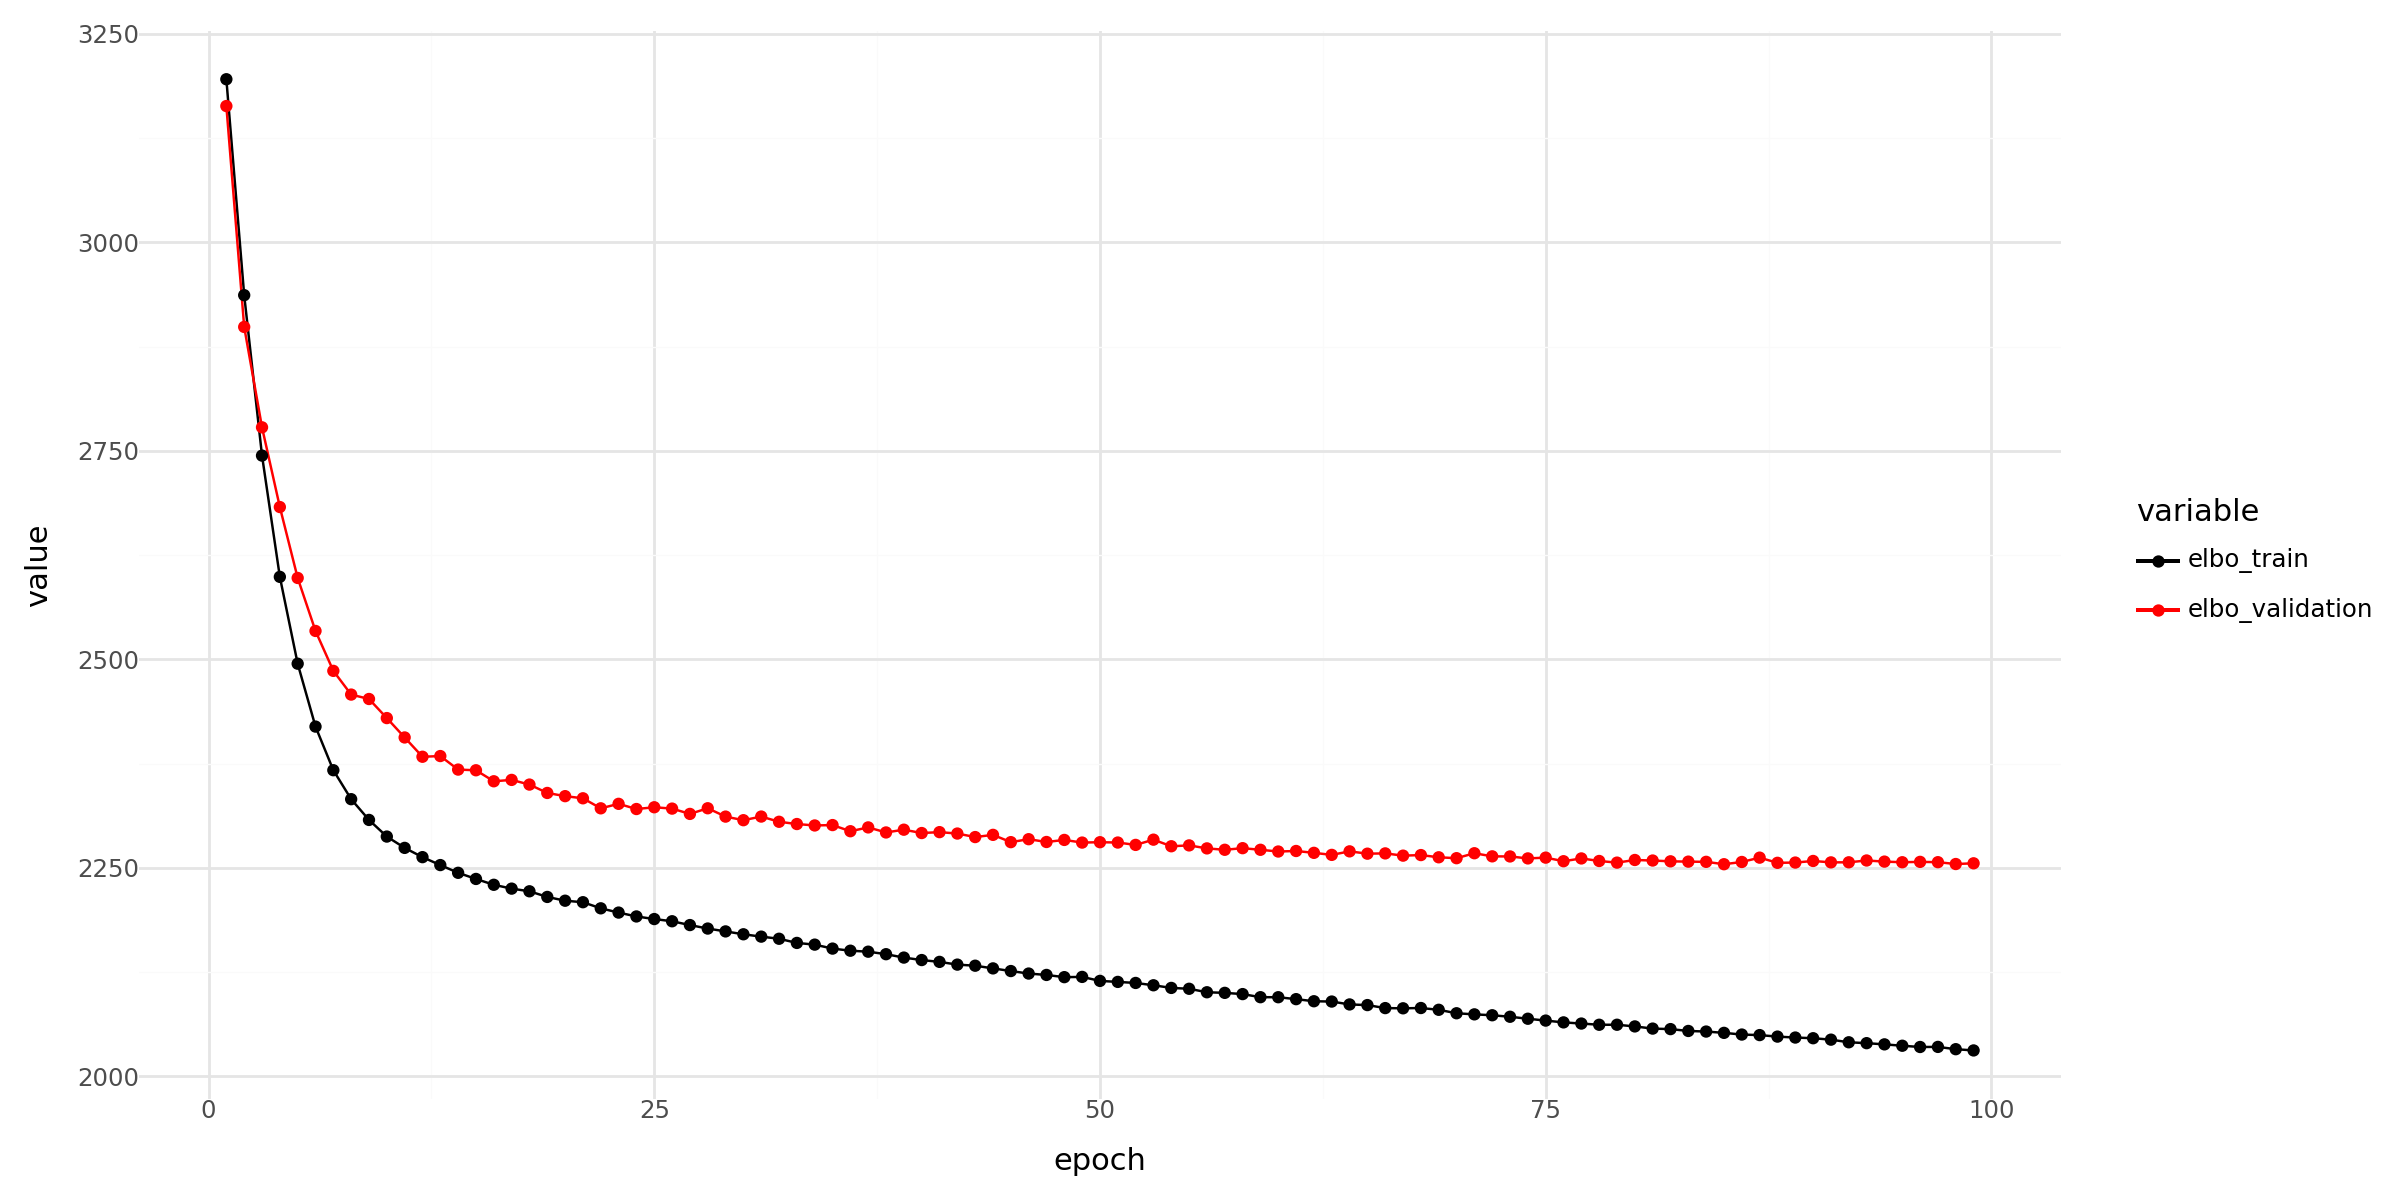

In [377]:
history_df = (
    model_scvi.history['elbo_train'].astype(float)
    .join(model_scvi.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('./scvi_wt_all_la_sevensson.png', dpi = 300)

print(p_)

In [378]:
adata.obsm["X_scVI"] = model_scvi.get_latent_representation()

In [379]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)
adata

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


AnnData object with n_obs × n_vars = 970 × 7548
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt', 'ribo', 'n_cells_by_counts',

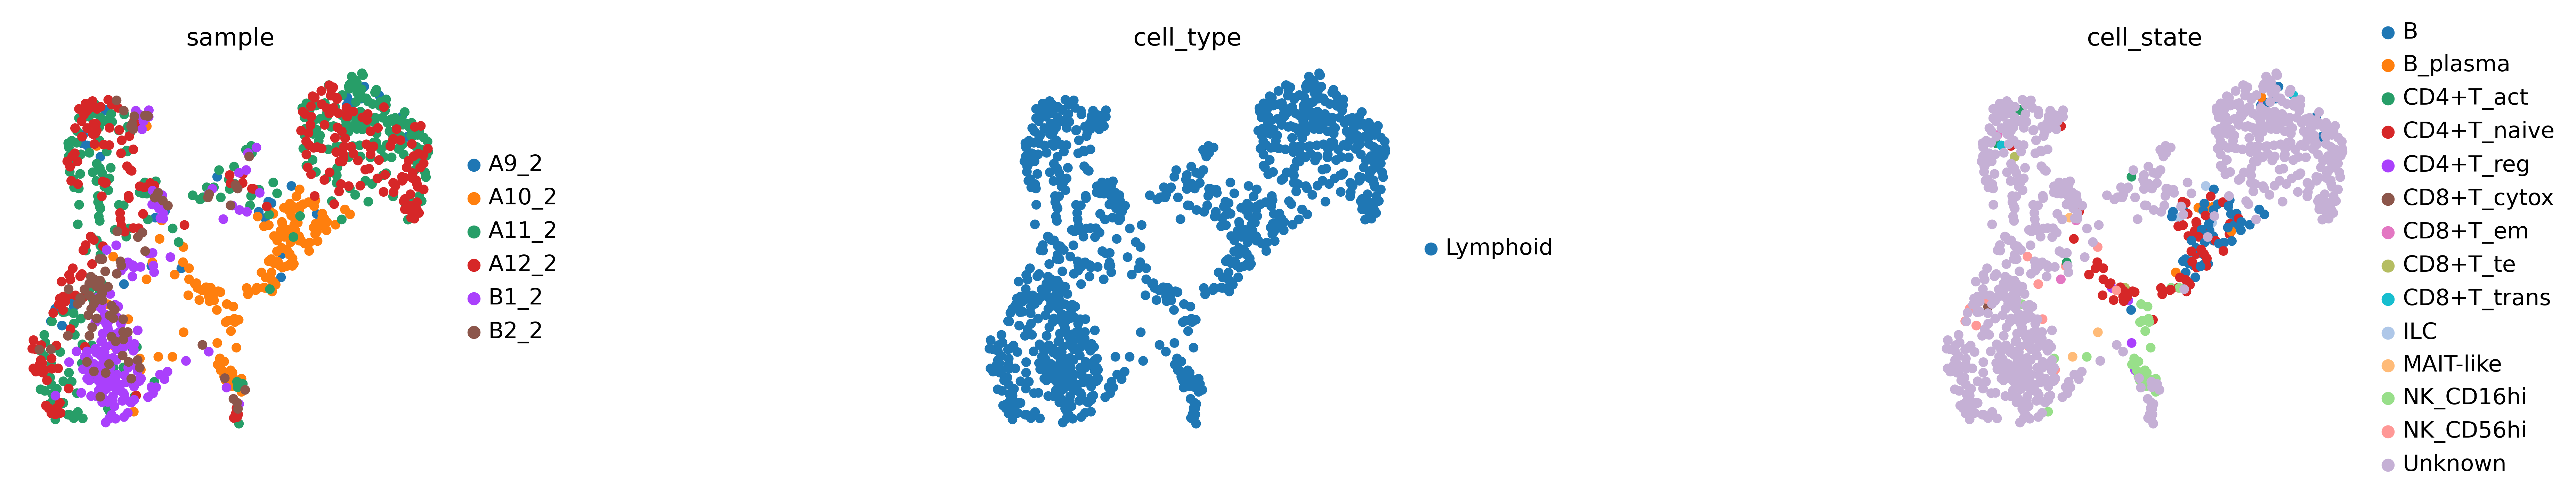

In [380]:
sc.pl.umap(adata, color=['sample', 'cell_type','cell_state'], wspace=1, frameon = False)

# scANVI

In [381]:
model_scanvi = scvi.model.SCANVI.from_scvi_model(model_scvi,unlabeled_category= 'Unknown')

In [382]:
model_scanvi.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.5.

Setup via `SCANVI.setup_anndata` with arguments:

{
│   'labels_key': 'cell_state',
│   'unlabeled_category': 'Unknown',
│   'layer': 'raw_counts',
│   'batch_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['sample', 'genotype'],
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │  970  │
│ n_extra_categorical_covs │   2   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  14   │
│          n_vars          │ 7548  │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │         adata.layers['raw_counts']         │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃ Categories  ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_state'] │      B      │          0          │
│                         │  B_plasma   │          1          │
│                         │  CD4+T_act  │          2          │
│                         │ CD4+T_naive │          3          │
│                         │  CD4+T_reg  │          4          │
│                         │ CD8+T_cytox │          5          │
│                         │  CD8+T_em   │          6          │
│                         │  CD8+T_te   │          7          │
│                         │ CD8+T_trans │          8          │
│                         │     ILC     │          9          │
│                         │  MAIT-like  │         10          │
│                         │  NK_CD16hi  │         11          │
│                         │  NK_CD56hi  │         12          │
│                         │   Unknown   │         13          │
└─────────────────────────┴─────────────┴─────────────────────┘

           extra_categorical_covs State Registry            
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['genotype'] │    Mdx     │          0          │
│                       │  MdxSCID   │          1          │
│                       │     WT     │          2          │
│                       │            │                     │
│  adata.obs['sample']  │    A9_2    │          0          │
│                       │   A10_2    │          1          │
│                       │   A11_2    │          2          │
│                       │   A12_2    │          3          │
│                       │    B1_2    │          4          │
│                       │    B2_2    │          5          │
│                       │            │                     │
└───────────────────────┴────────────┴─────────────────────┘

In [383]:
model_scanvi.train(max_epochs= 10, devices= [1], accelerator= 'gpu',check_val_every_n_epoch = 1, enable_progress_bar = True, )

INFO     Training for 10 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 10/10: 100%|██████████| 10/10 [00:01<00:00,  9.99it/s, v_num=1, train_loss_step=1.89e+3, train_loss_epoch=2.04e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:01<00:00,  9.88it/s, v_num=1, train_loss_step=1.89e+3, train_loss_epoch=2.04e+3]


In [384]:
model_scanvi.save('./', overwrite=True, prefix= 'scanvi_wt_all')

In [385]:
adata.obsm["X_scANVI"] = model_scanvi.get_latent_representation()

## Evaluate model performance a la Svensson

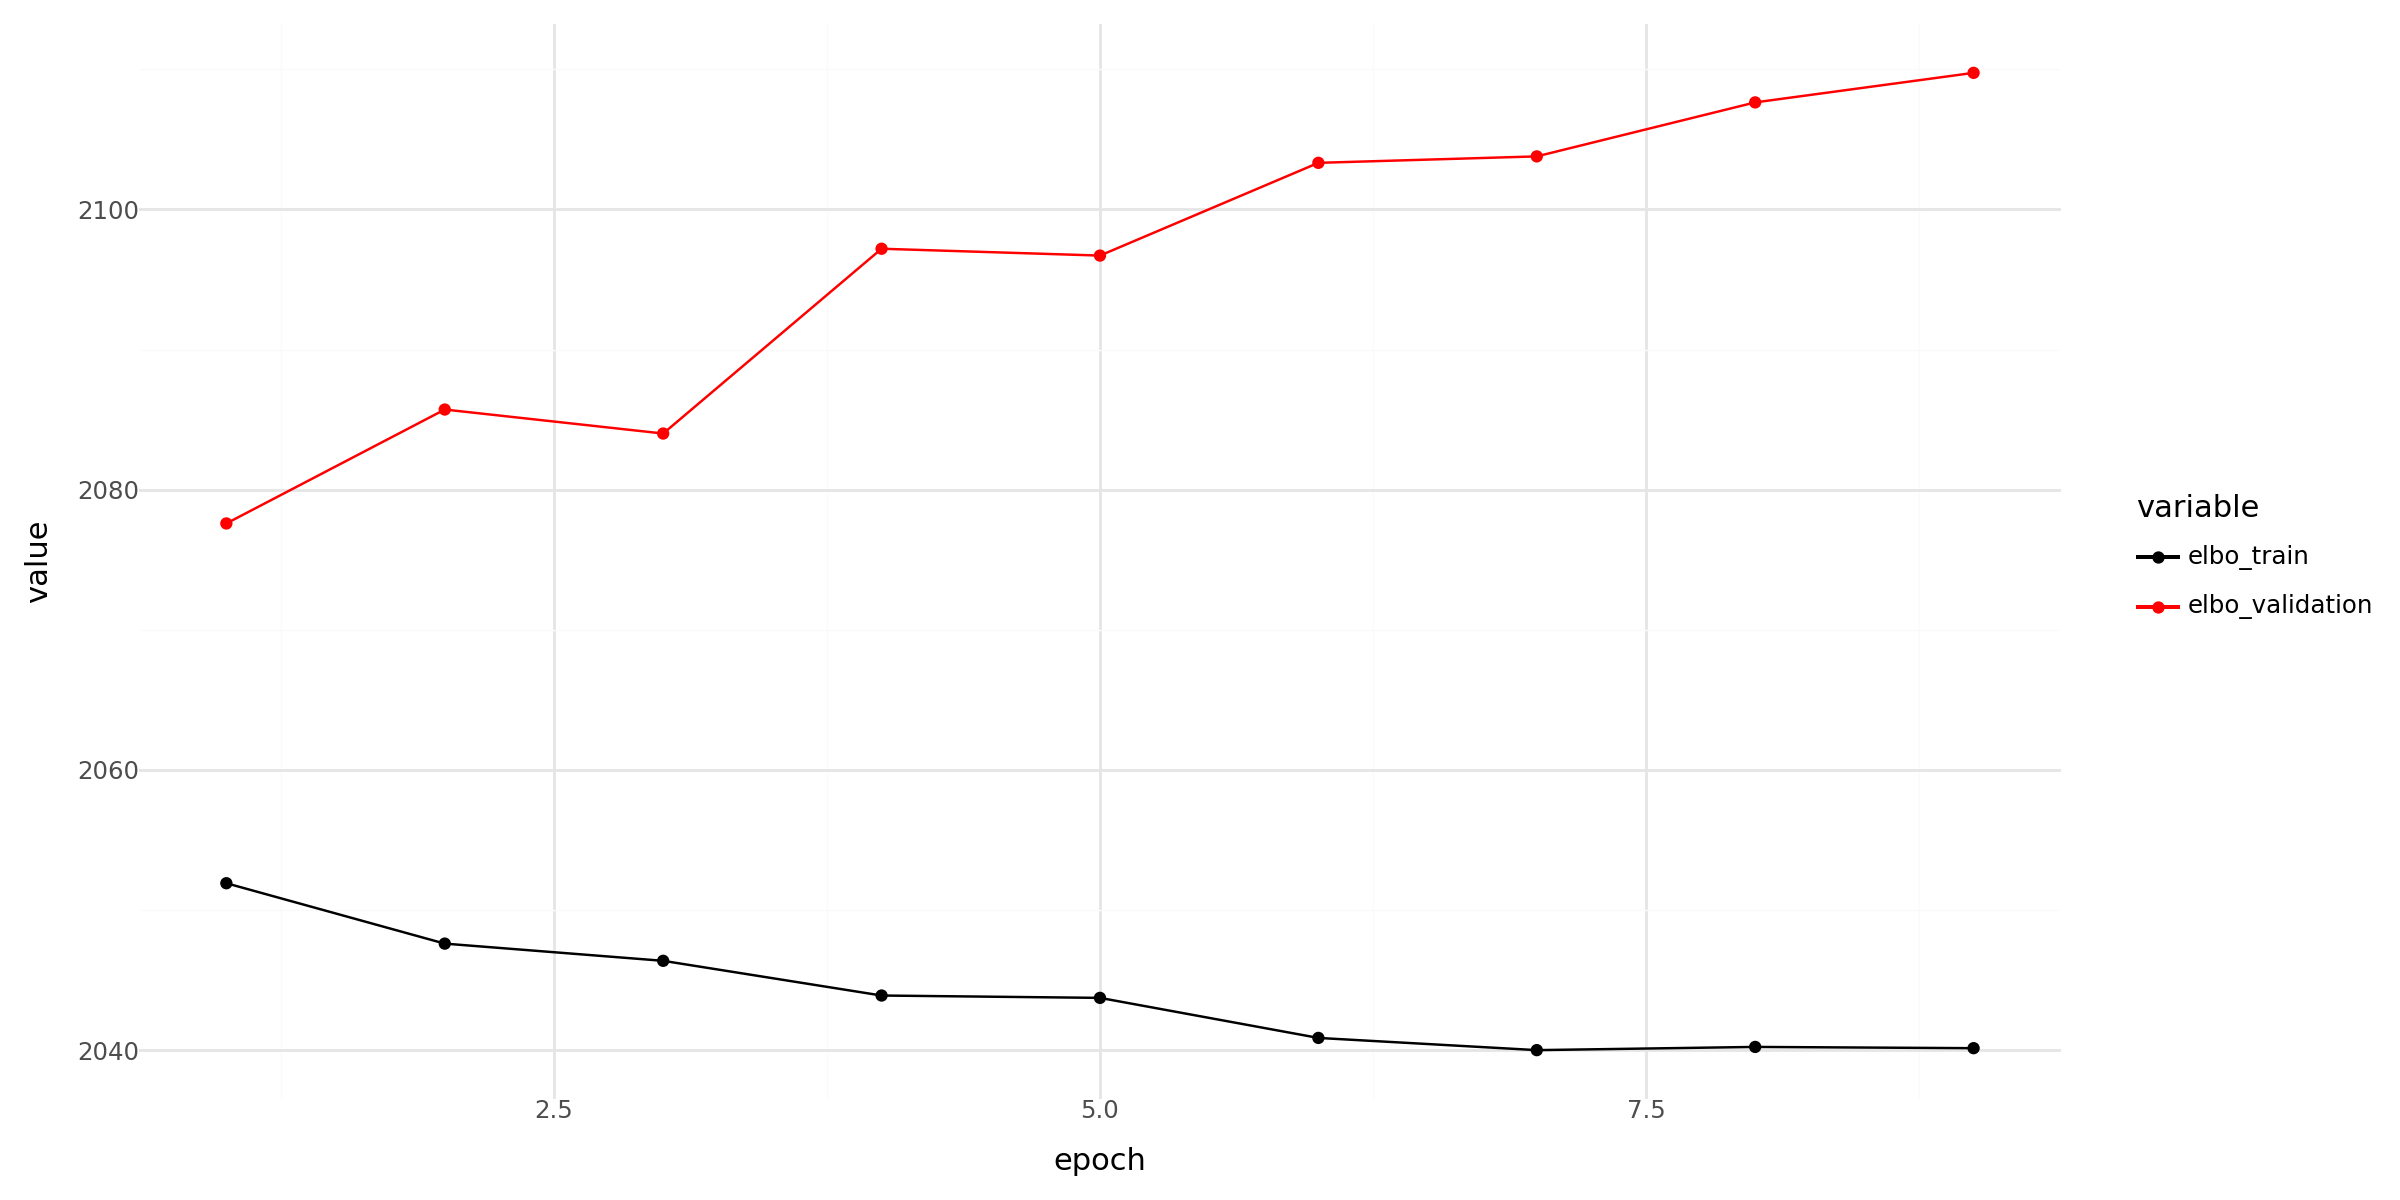

In [386]:
history_df = (
    model_scanvi.history['elbo_train'].astype(float)
    .join(model_scanvi.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('scanvi_wt_all_la_sevensson.png', dpi = 300)

print(p_)

In [387]:
adata.obs["C_scANVI"] = model_scanvi.predict(adata)

In [388]:
adata.obsm["X_scANVI"] = model_scanvi.get_latent_representation(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


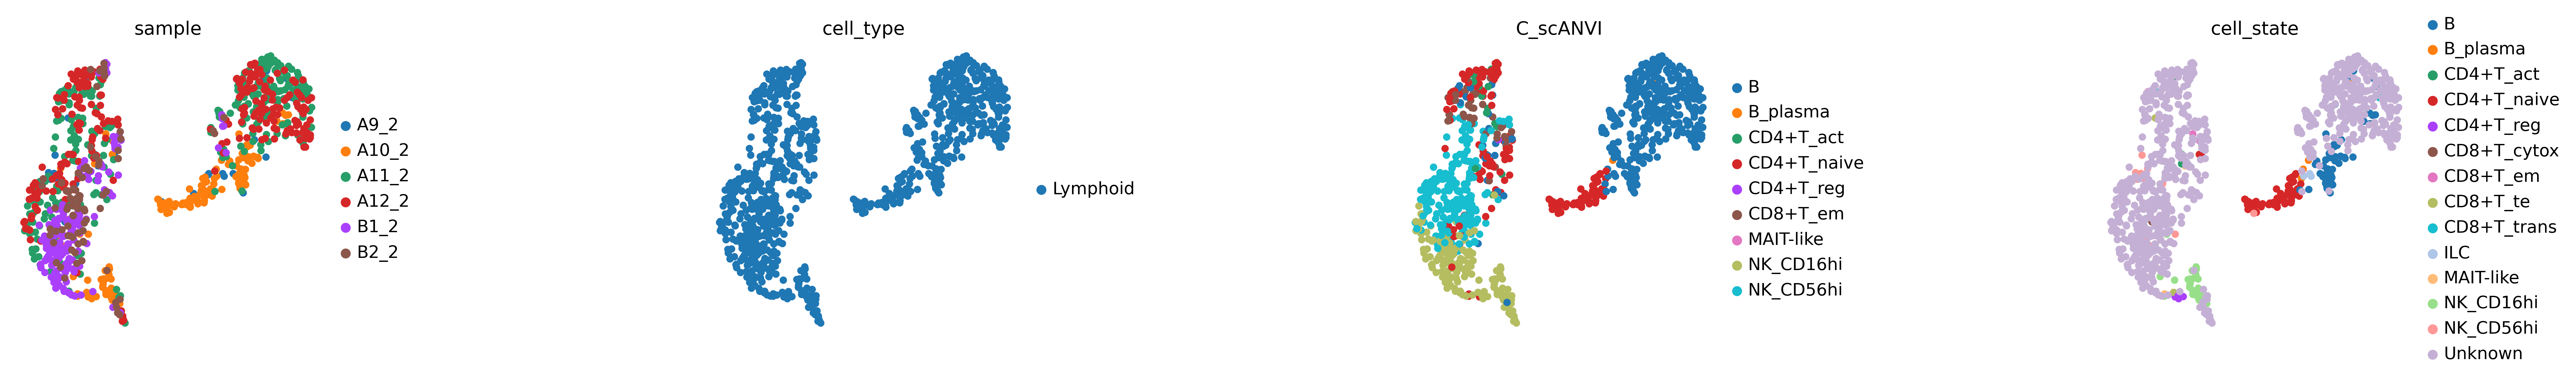

In [389]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata)
sc.pl.umap(adata, color=['sample', 'cell_type',"C_scANVI",'cell_state'], wspace=1, frameon = False)

In [390]:
stats = pd.crosstab(adata.obs["C_scANVI"], adata.obs["genotype"])
stats

genotype,Mdx,MdxSCID,WT
C_scANVI,,,
B,296,16,61
B_plasma,0,0,3
CD4+T_act,14,2,1
CD4+T_naive,42,50,71
CD4+T_reg,1,0,0
CD8+T_em,33,6,5
MAIT-like,0,0,1
NK_CD16hi,39,91,32
NK_CD56hi,106,85,15


# Export data

In [391]:
adata_export_merged = anndata.AnnData(X = adata_raw.X, var = adata_raw.var, obs = adata.obs)
adata_export_merged

AnnData object with n_obs × n_vars = 970 × 7548
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt', 'ribo', 'n_cells_by_counts',

In [392]:
adata_export = adata_export_merged[adata_export_merged.obs['batch'].isin(['query'])]
adata_export

View of AnnData object with n_obs × n_vars = 781 × 7548
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt', 'ribo', 'n_cells_by_

In [393]:
query_export = anndata.AnnData(X = query.X, var = query.var, obs = adata_export.obs)
query_export

AnnData object with n_obs × n_vars = 781 × 32285
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt', 'ribo', 'n_cells_by_counts'

In [394]:
query_export.obs['C_scANVI'].value_counts()

C_scANVI
B              312
NK_CD56hi      191
NK_CD16hi      130
CD4+T_naive     92
CD8+T_em        39
CD4+T_act       16
CD4+T_reg        1
Name: count, dtype: int64

In [395]:
query_export.obs['cell_state'] = query_export.obs['C_scANVI'].copy()
#query_export.obs['cell_state'] = query_export.obs[''cell_state''].replace('vCM3_stressed', 'vCM3')
query_export

AnnData object with n_obs × n_vars = 781 × 32285
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt', 'ribo', 'n_cells_by_counts'

In [396]:
query_export.obs['cell_state'].value_counts()

cell_state
B              312
NK_CD56hi      191
NK_CD16hi      130
CD4+T_naive     92
CD8+T_em        39
CD4+T_act       16
CD4+T_reg        1
Name: count, dtype: int64

In [397]:
tab = pd.crosstab(query_export.obs['cell_state'],query_export.obs['genotype'])
tab

genotype,Mdx,MdxSCID
cell_state,,
B,296,16
CD4+T_act,14,2
CD4+T_naive,42,50
CD4+T_reg,1,0
CD8+T_em,33,6
NK_CD16hi,39,91
NK_CD56hi,106,85


In [398]:
print(X_is_raw(query_export))

True


In [399]:
query_export.layers['raw_counts'] = query_export.X

In [400]:
sc.pp.normalize_total(query_export, target_sum= 1e6)
sc.pp.log1p(query_export)
query_export.layers['normalized'] = query_export.X

normalizing counts per cell
    finished (0:00:00)


computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


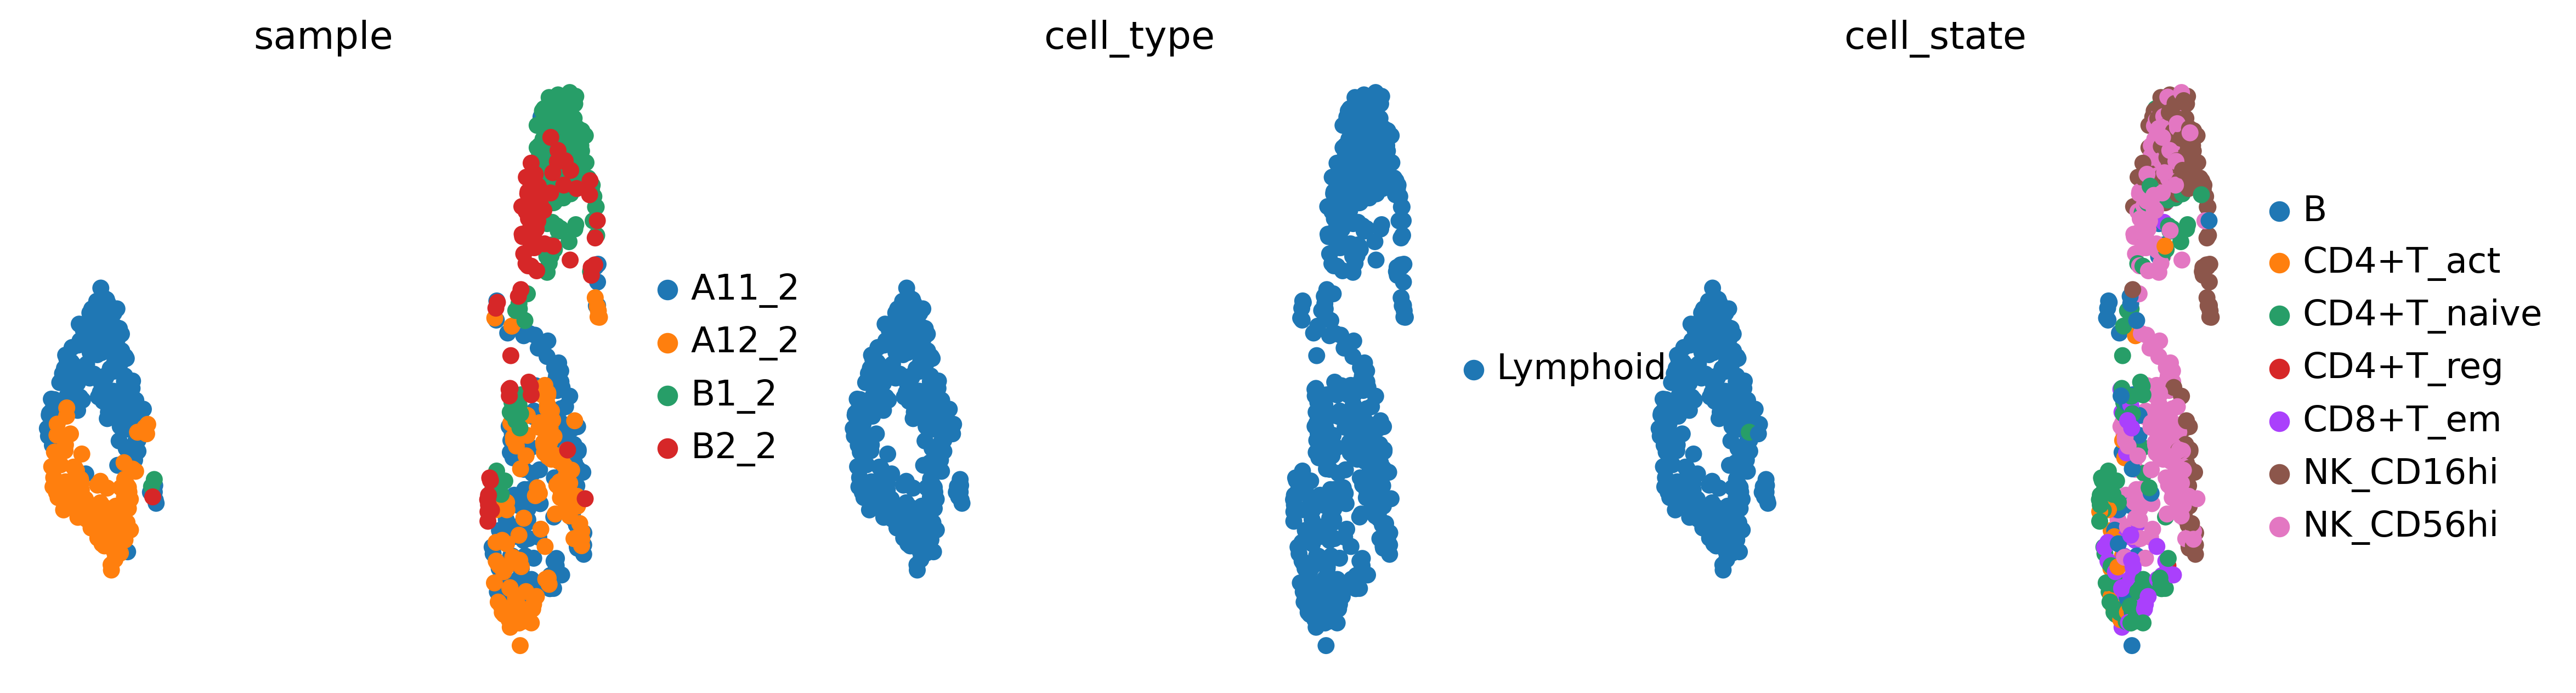

In [401]:
sc.pp.pca(query_export)
sc.pp.neighbors(query_export)
sc.tl.umap(query_export)
sc.pl.umap(query_export, color = ['sample', 'cell_type','cell_state'], frameon = False)

In [402]:
query_export.write(f'../../data/dmd_annotated_lymphoid_mdx,mdxscid_{timestamp}.h5ad')

# SCIB metrics

In [403]:
adata

AnnData object with n_obs × n_vars = 970 × 7548
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt', 'ribo', 'n_cells_by_counts',

In [404]:
scib = scib_metrics.benchmark.Benchmarker(adata, batch_key = 'sample', label_key = 'C_scANVI', embedding_obsm_keys = ['X_scVI', 'X_scANVI','X_pca'])

In [405]:
scib.benchmark()

computing PCA
    with n_comps=50
    finished (0:00:00)


Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]

INFO     B_plasma consists of a single batch or is too small. Skip.                                                
INFO     CD4+T_reg consists of a single batch or is too small. Skip.                                               
INFO     MAIT-like consists of a single batch or is too small. Skip.                                               


Embeddings:  33%|███▎      | 1/3 [00:03<00:06,  3.28s/it]

INFO     B_plasma consists of a single batch or is too small. Skip.                                                
INFO     CD4+T_reg consists of a single batch or is too small. Skip.                                               
INFO     MAIT-like consists of a single batch or is too small. Skip.                                               


Embeddings:  67%|██████▋   | 2/3 [00:04<00:01,  1.88s/it]

INFO     B_plasma consists of a single batch or is too small. Skip.                                                
INFO     CD4+T_reg consists of a single batch or is too small. Skip.                                               
INFO     MAIT-like consists of a single batch or is too small. Skip.                                               


Embeddings: 100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


In [406]:
scib.get_results()

,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,,,,,
X_scVI,0.0,0.738356,0.777161,0.900046,0.705701,1.0,0.800008,0.947933,0.524678,0.710263,0.796576,0.624253,0.693182
X_scANVI,0.0,1.0,1.0,1.0,1.0,0.921781,1.0,1.0,1.0,1.0,0.984356,0.8,0.873742
X_pca,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


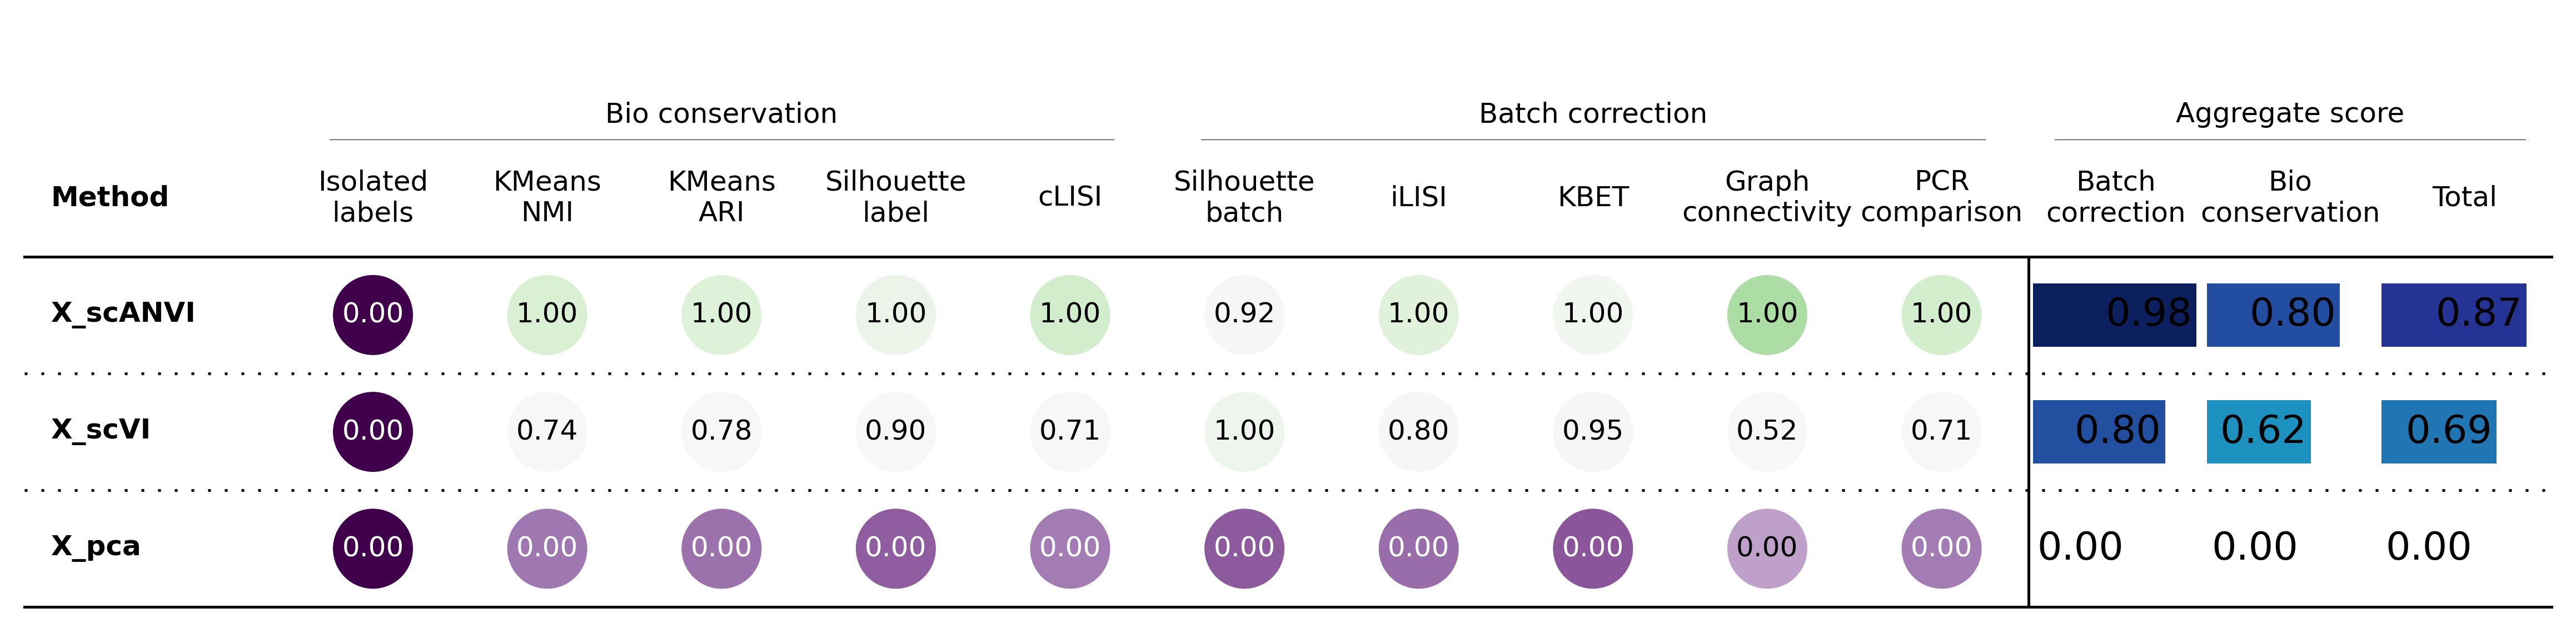

In [407]:
scib.plot_results_table()